<a href="https://colab.research.google.com/github/Zivvvo/melanoma_classifier/blob/master/VGG19_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import keras

In [3]:
print(tf.__version__)

2.3.0


In [6]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [7]:
TRAIN = "train"
TEST = "test"
MODEL_PATH="models/"

In [8]:
cd /content/drive/My\ Drive/Colab\ Notebooks/SC_classifier

/content/drive/My Drive/Colab Notebooks/SC_classifier


In [9]:
ls

data/              model_architecture.h5    prediction.ipynb          train/
demo.ipynb         model_architecture.json  SC_model_generator.ipynb
latest_model.hdf5  models/                  test/


In [10]:
data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255, rotation_range = 180, horizontal_flip=True, vertical_flip = True, width_shift_range=0.2, zoom_range = [1,1.3])

In [11]:
dataset = data_generator.flow_from_directory("train", batch_size = 32)

Found 2637 images belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


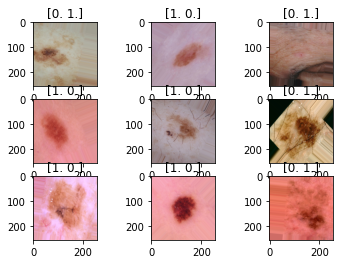

In [12]:
batch_num = 0
for item_num in range(9):
    data, labels = dataset[batch_num]
    ax = plt.subplot(3,3,item_num+1)
    ax.imshow(data[item_num])
    plt.title(labels[item_num])

In [13]:
from keras import backend as K
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(os.path.join(MODEL_PATH, "latest_model.h5"), monitor = 'loss', verbose = 1, save_best_only=True, mode='auto', period = 1)

In [14]:
#define a transfer learning model based on VGG19
from keras.models import Input, Model
from keras.layers import Activation, Dropout, Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization, SeparableConv2D, add, GlobalAveragePooling2D

image_size = 256
def model(input_shape):
    vgg = tf.keras.applications.VGG19(include_top =False, pooling = 'avg', weights='imagenet', input_shape = (image_size, image_size, 3))
    vgg.trainable = False

    trainable_layers = vgg.layers[16:]
    print(trainable_layers)

    for layers in trainable_layers:
      layers.trainable = True

    #adding a few dense layers in the end (Functional API)
    #method, use the output of vgg as the input for the next layer, then when defining the model using Model()
    #use Model(vgg.input, final output)

    x_input = Dense(200, activation = "relu")(vgg.output)
    x = Dropout(0.5)(x_input)
    x = Dense(2, activation ="softmax")(x_input)

    custom_model = Model(vgg.input, x)
    
    return custom_model


In [15]:
vgg_model = model(data[0].shape)
vgg_model.summary()

80142336/80134624 [==============================] - 1s 0us/step
[<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f45a04267f0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f45a042f320>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f45a042feb8>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f45a04345c0>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f45a0434550>, <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f45a043fa20>, <tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f45a044a550>]
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
____________

In [16]:
vgg_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics = ["accuracy"])

In [18]:
vgg_model.fit(dataset, epochs = 50, callbacks = [checkpoint])

Epoch 1/50
83/83 [==============================] - ETA: 0s - loss: 0.2599 - accuracy: 0.8783
Epoch 00001: loss did not improve from 0.23336
83/83 [==============================] - 45s 545ms/step - loss: 0.2599 - accuracy: 0.8783
Epoch 2/50
83/83 [==============================] - ETA: 0s - loss: 0.2338 - accuracy: 0.8984
Epoch 00002: loss did not improve from 0.23336
83/83 [==============================] - 45s 539ms/step - loss: 0.2338 - accuracy: 0.8984
Epoch 3/50
83/83 [==============================] - ETA: 0s - loss: 0.2249 - accuracy: 0.8953
Epoch 00003: loss improved from 0.23336 to 0.22489, saving model to models/latest_model.h5
83/83 [==============================] - 46s 558ms/step - loss: 0.2249 - accuracy: 0.8953
Epoch 4/50
83/83 [==============================] - ETA: 0s - loss: 0.2239 - accuracy: 0.8972
Epoch 00004: loss improved from 0.22489 to 0.22393, saving model to models/latest_model.h5
83/83 [==============================] - 47s 561ms/step - loss: 0.2239 - accur

In [20]:
testset = data_generator.flow_from_directory(TEST)

Found 660 images belonging to 2 classes.


In [21]:
vgg_model.evaluate(testset)

21/21 [==============================] - 201s 10s/step - loss: 0.4219 - accuracy: 0.8606


[0.42191916704177856, 0.8606060743331909]

Prediction:[[9.9981266e-01 1.8731366e-04]], actual result: [1. 0.]


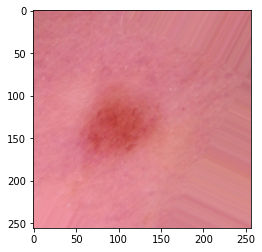

In [24]:
#predictions on test set examples
batch_num = 18
index_num = 19

x = testset[batch_num][0][index_num]
prediction = vgg_model.predict(x[np.newaxis, ...])
print("Prediction:"+ str(prediction) + ", actual result: "+ str(dataset[batch_num][1][index_num]))
plt.imshow(x)